# Modeling Experiments



Python notebook re: training more complex models (ensembles, regularized, etc.); including performance tables/plots across folds; documenting failed experiments and iteration decisions.

Input(s):
- `../data/processed/train_calib_selected.csv`: training/calibration split with only selected features plus metadata (`user`, `gesture`, `stage`)
- `../results/feature_selection.csv`: produced by the feature selection step; used here only for reporting.

Main output(s):
- model_comparison.csv: Tabular record of model family, hyperparameters, and KPI scores

Other output(s):
- TBD

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.base import clone

# Global config
RANDOM_STATE = 13
PERSONALIZATION_K = 5 # Folds per user for within-user evaluation

# Define primary & secondary metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

PERSONALIZATION RATIONALE FOR GNI RESEARCH:
- sEMG signals exhibit high inter-user variability due to anatomical differences,
  electrode placement, skin impedance, and motor unit recruitment patterns
- Personalization evaluates model performance on the SAME user's unseen data,
  simulating real-world deployment where users calibrate the interface
- (Contrasts with generalization (`GroupKFold`) which tests on unseen users)
- Personalization is essential for practical neuromotor interfaces as demonstrated
  in the GNI research by Kaifosh et al. (2025)
- `StratifiedKFold` maintains gesture class distribution within each user's splits

In [2]:
# Define primary & secondary metrics for personalization
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# Define CV strategy for PERSONALIZATION (within-user eval)
# split each user's data into train/test to eval personalization accuracy
from sklearn.model_selection import StratifiedKFold

# Use StratifiedKFold w/i each user to maintain gesture distribution
PERSONALIZATION_K = 5
cv_strategy = StratifiedKFold(n_splits=PERSONALIZATION_K, shuffle=True, random_state=RANDOM_STATE)

# Confirm
print(f"Cross-validation strategy: StratifiedKFold with {PERSONALIZATION_K} splits (within-user personalization)")

Cross-validation strategy: StratifiedKFold with 5 splits (within-user personalization)


In [3]:
# Load training/calibration data w/ selected features
df_train = pd.read_csv("../data/processed/train_calib_selected.csv")

TARGET = 'gesture'
GROUP = 'user'
# 'stage' included as metadata
metadata_cols = [GROUP, TARGET, 'stage'] 
final_features = [col for col in df_train.columns if col not in metadata_cols]

X = df_train[final_features]
y_raw = df_train[TARGET]
groups = df_train[GROUP]

# Encode target labels
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_raw), index=y_raw.index)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Unique users (groups): {groups.nunique()}, Unique gestures: {y.nunique()}")

X shape: (108187, 11), y shape: (108187,)
Unique users (groups): 100, Unique gestures: 9


In [4]:
# Inspect
X.head(5)

,ch05_rms,ch04_rms,ch03_maxabs,ch10_rms,ch06_maxabs,ch07_mav,ch15_rms,ch13_rms,ch02_rms,ch05_thresh2-events,ch12_maxabs
0,32.033817,25.384038,108.193359,27.218443,171.539795,20.944720,40.340477,42.707853,18.001385,4.0,106.773613
1,13.096003,10.759559,33.722424,54.640630,72.098503,18.294837,12.649023,26.915713,9.743423,2.0,129.517532
2,36.147437,27.193224,88.790611,57.820163,121.262909,15.610900,28.624315,38.212289,15.999259,8.0,166.150330
3,10.821121,9.922516,35.281422,64.734727,41.897194,10.157973,23.454391,43.449389,13.775205,1.0,173.706589
4,13.949151,10.327956,42.624359,41.144490,102.308434,25.153957,23.079407,33.550284,10.680136,1.0,102.581963


In [5]:
# Create label mapping using original encoder from data loading
# already encoded y_raw to y, so use same encoder
class_names = le.classes_

# dataframe for label mapping
label_mapping_df = pd.DataFrame({
    'Encoded_label': range(len(class_names)),
    'Gesture_Class': class_names
})

# Inspect
label_mapping_df

,Encoded_label,Gesture_Class
0,0,index_press
1,1,index_release
2,2,middle_press
3,3,middle_release
4,4,thumb_click
5,5,thumb_down
6,6,thumb_in
7,7,thumb_out
8,8,thumb_up


## Modeling experiments (cross-validation)

### Define models to test

In [6]:
# Define reusable preprocessing pipeline step
preprocessor = Pipeline([('scaler', StandardScaler())])

models_to_test = {
    'DummyClassifier': Pipeline([
        ('prep', preprocessor),  # Add preprocessor step 
        ('clf', DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
    ]),
    'LogisticRegression_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE
        ))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100, max_depth=6, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    'XGBoost': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(
            n_estimators=100, 
            max_depth=6,
            eval_metric='mlogloss',
            random_state=RANDOM_STATE, 
            n_jobs=1
        ))
    ])
}

In [7]:
import joblib
from pathlib import Path

# Cache directory for model results
CACHE_DIR = Path("../cache")
CACHE_DIR.mkdir(exist_ok=True)

# Within-user cross-validation
def run_personalization_cv(model, X, y, groups, name, k_folds, scoring_metrics, use_cache=True):
    """
    Evaluates model performance averaged across all users using StratifiedKFold within each user
    """
    
    cache_file = CACHE_DIR / f"personalization_{name}.pkl"
    
    # Return cached results if available
    if use_cache and cache_file.exists():
        print(f"Loading cached results for {name}...")
        return joblib.load(cache_file)
    
    print(f"Evaluating {name} for personalization...")
    
    unique_users = groups.unique()
    all_f1_scores = []
    all_acc_scores = []
    users_evaluated = 0
    users_skipped = 0
    
    cv_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

    for user in unique_users:
        # Isolate data for current user
        user_indices = groups[groups == user].index
        X_user = X.loc[user_indices]
        y_user = y.loc[user_indices]
        
        # Ensure sufficient samples and classes for StratifiedKFold
        if len(y_user.unique()) < k_folds:
             # Skip user if have fewer unique classes than folds, or too few samples overall
             print(f"Warning: Skipping user {user} (N={len(y_user)}) due to insufficient samples/classes for CV.")
             users_skipped += 1
             continue
        
        # clone model to ensure fresh fit for each metric/user combination
        user_model = clone(model) 
        
        # Cross-validation w/i current user's data
        f1_scores = cross_val_score(
            user_model, X_user, y_user, cv=cv_splitter, scoring=scoring_metrics['f1_macro'], n_jobs=-1
        )
        acc_scores = cross_val_score(
            user_model, X_user, y_user, cv=cv_splitter, scoring=scoring_metrics['accuracy'], n_jobs=-1 
        )
        
        all_f1_scores.extend(f1_scores)
        all_acc_scores.extend(acc_scores)
        users_evaluated += 1

    # Calculate overall mean & stdev across all folds (all users combined)
    mean_f1 = np.mean(all_f1_scores)
    std_f1 = np.std(all_f1_scores)
    mean_acc = np.mean(all_acc_scores)
    std_acc = np.std(all_acc_scores)

    # Placeholder for params (assuming initial run uses defaults/pre-tuned values)
    hyperparams = model.named_steps['clf'].get_params(deep=False) 
    
    result = {
        'Model': name,
        'Mean_Accuracy': mean_acc,
        'Std_Accuracy': std_acc,
        'Mean_F1_Macro': mean_f1,
        'Std_F1_Macro': std_f1,
        'Hyperparameters': str(hyperparams),
        'N_Users_Evaluated': users_evaluated,
        'N_Users_Skipped': users_skipped,
        'Total_Folds': len(all_f1_scores)
    }
    
    print(f"{name}: {users_evaluated} users evaluated, {users_skipped} skipped, {len(all_f1_scores)} total folds")
    
    # Cache result
    if use_cache:
        joblib.dump(result, cache_file)
    
    return result

# # (OPTIONAL) Clear cache files
# import os
# for model_name in ['LogisticRegression_L2', 'XGBoost', 'RandomForest']:
#     cache_file = CACHE_DIR / f"personalization_{model_name}.pkl"
#     if cache_file.exists():
#         os.remove(cache_file)
#         print(f"Deleted cached file for {model_name}")

# Use personalization eval w/ caching
results = []
for name, model in models_to_test.items():
    res = run_personalization_cv(model, X, y, groups, name, PERSONALIZATION_K, scoring_metrics, use_cache=True)
    results.append(res)
    
results_df = pd.DataFrame(results).sort_values(by='Mean_F1_Macro', ascending=False).reset_index(drop=True)
results_df

Loading cached results for DummyClassifier...
Loading cached results for LogisticRegression_L2...
Loading cached results for RandomForest...
Loading cached results for XGBoost...


,Model,Mean_Accuracy,Std_Accuracy,Mean_F1_Macro,Std_F1_Macro,Hyperparameters,N_Users_Evaluated,N_Users_Skipped,Total_Folds
0,LogisticRegression_L2,0.639536,0.121690,0.595724,0.121123,"{'C': 1.0, 'class_weight': None, 'dual': False...",100,0,500
1,XGBoost,0.623349,0.131845,0.583489,0.125409,"{'objective': 'binary:logistic', 'base_score':...",100,0,500
2,RandomForest,0.610451,0.120911,0.539673,0.115261,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",100,0,500
3,DummyClassifier,0.146502,0.043680,0.108575,0.022345,"{'constant': None, 'random_state': 13, 'strate...",100,0,500


### Model comparison summary

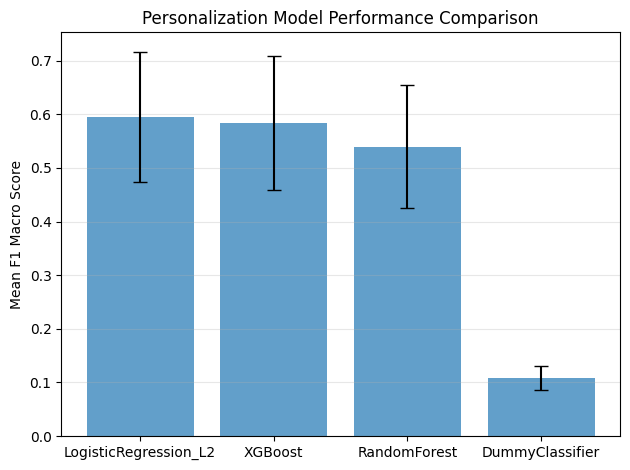

In [8]:
# Plot
bars = plt.bar(results_df['Model'], results_df['Mean_F1_Macro'], 
               yerr=results_df['Std_F1_Macro'], capsize=5, alpha=0.7)
plt.ylabel(f'Mean F1 Macro Score')
plt.title('Personalization Model Performance Comparison')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Save model_comparison.csv

In [9]:
# Clean results_df before saving (remove any NaN columns from previous runs)
clean_results = results_df.copy()

# Remove any columns that are all NaN/contain NaN values from old analysis
clean_results = clean_results.loc[:, ~clean_results.isna().all()]
clean_results = clean_results.dropna(axis=1, how='all')

# Save comparison table
RESULTS_PATH = "../results/model_comparison.csv"
os.makedirs(os.path.dirname(RESULTS_PATH), exist_ok=True)
summary_to_save = clean_results.copy()
summary_to_save['experiment_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')

if os.path.exists(RESULTS_PATH):
    prev = pd.read_csv(RESULTS_PATH)
    # Ensure we're using the correct column name for deduplication
    combined = pd.concat([prev, summary_to_save], ignore_index=True)
    combined = combined.drop_duplicates(subset=['Model'], keep='last')
else:
    combined = summary_to_save

combined.to_csv(RESULTS_PATH, index=False)
print(f"Saved/updated model comparison log to: {RESULTS_PATH}")

Saved/updated model comparison log to: ../results/model_comparison.csv


## Model selection and interpretation

### Feature importance analysis

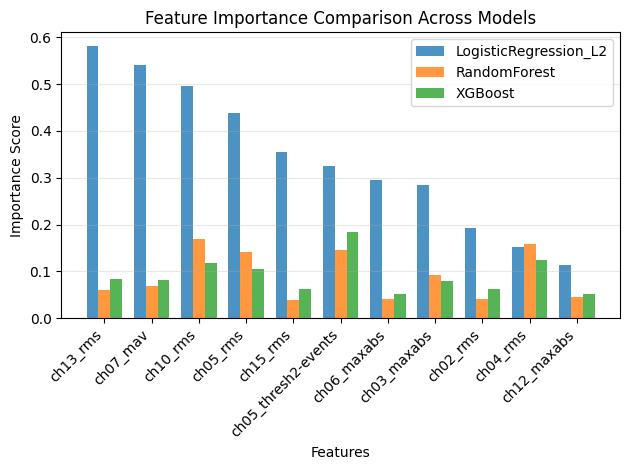

In [10]:
# Analyze feature importance for ALL models
feature_importance_results = {}

# Fix XGBoost warning by removing use_label_encoder parameter
models_to_test['XGBoost'] = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=100, max_depth=6,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE, n_jobs=1
    ))
])

model_names = [key for key in models_to_test.keys() if key != 'DummyClassifier']

# Collect feature importance data
importance_data = {}
for model_name in model_names:
    pipeline = models_to_test[model_name]
    pipeline.fit(X, y) 
    
    if hasattr(pipeline.named_steps['clf'], 'feature_importances_'):
        importances = pipeline.named_steps['clf'].feature_importances_
    else:
        coefficients = pipeline.named_steps['clf'].coef_
        importances = np.mean(np.abs(coefficients), axis=0)
    
    feature_imp = pd.DataFrame({
        'feature': final_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    feature_importance_results[model_name] = feature_imp
    importance_data[model_name] = feature_imp.set_index('feature')['importance']

# Create grouped bar plot
importance_df = pd.DataFrame(importance_data)
importance_df = importance_df.sort_values('LogisticRegression_L2', ascending=False)

x = np.arange(len(importance_df))
width = 0.25

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, importance_df['LogisticRegression_L2'], width, label='LogisticRegression_L2', alpha=0.8)
bars2 = ax.bar(x, importance_df['RandomForest'], width, label='RandomForest', alpha=0.8)
bars3 = ax.bar(x + width, importance_df['XGBoost'], width, label='XGBoost', alpha=0.8)

ax.set_xlabel('Features')
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison Across Models')
ax.set_xticks(x)
ax.set_xticklabels(importance_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [11]:
# Consolidate into df
consolidated_df = pd.DataFrame()
for model_name in model_names:
    df = feature_importance_results[model_name].copy()
    df = df.rename(columns={'importance': f'{model_name}_importance'})
    df = df.set_index('feature')
    consolidated_df = pd.concat([consolidated_df, df], axis=1)

# Inspect
consolidated_df

,LogisticRegression_L2_importance,RandomForest_importance,XGBoost_importance
feature,,,
ch13_rms,0.581927,0.060864,0.082916
ch07_mav,0.542140,0.067896,0.081996
ch10_rms,0.496048,0.169770,0.118157
ch05_rms,0.438876,0.141840,0.104281
ch15_rms,0.354277,0.038674,0.062118
ch05_thresh2-events,0.325204,0.145513,0.184478
ch06_maxabs,0.295540,0.040450,0.050773
ch03_maxabs,0.284886,0.091442,0.078129
ch02_rms,0.191473,0.040872,0.061619


In [12]:
# feature ranking comparison table
comparison_data = {}
for model_name, feature_imp in feature_importance_results.items():
    df = feature_imp.copy()
    df['rank'] = range(1, len(df) + 1)
    comparison_data[model_name] = df.set_index('feature')['rank']

comparison_df = pd.DataFrame(comparison_data)

# Add average rank as new col & reset index to get feature as col
comparison_df['average_rank'] = comparison_df.mean(axis=1)
comparison_df = comparison_df.sort_values('average_rank').reset_index()

# Inspect: final comparison table
comparison_df

,feature,LogisticRegression_L2,RandomForest,XGBoost,average_rank
0,ch10_rms,3,1,3,2.333333
1,ch05_thresh2-events,6,3,1,3.333333
2,ch05_rms,4,4,4,4.000000
3,ch13_rms,1,7,5,4.333333
4,ch04_rms,10,2,2,4.666667
5,ch07_mav,2,6,6,4.666667
6,ch03_maxabs,8,5,7,6.666667
7,ch15_rms,5,11,8,8.000000
8,ch02_rms,9,9,9,9.000000
9,ch06_maxabs,7,10,11,9.333333


## Confusion matrix diagnostics

Best performing model: LogisticRegression_L2 (F1 Macro: 0.5957)
Processed users: 100 (0 skipped)
Total samples in analysis: 108187


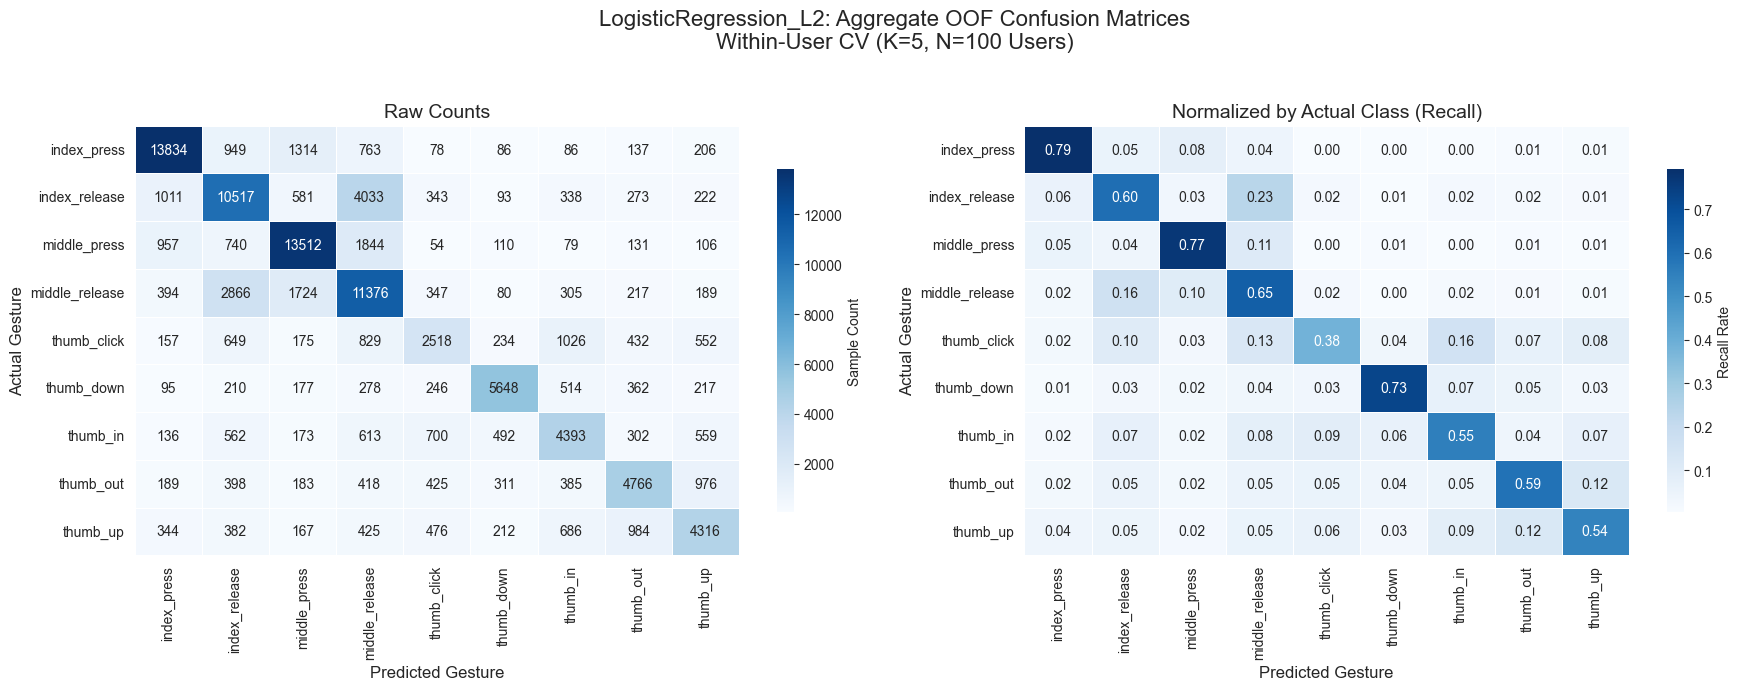

In [13]:
# Diagnostics: confusion matrix analysis
# Out-of-fold predictions from within-user cross-validation to analyze systematic misclassification patterns

sns.set_style("whitegrid")

# ID best performing model re: F1 Macro score
best_model_row = results_df.loc[results_df['Mean_F1_Macro'].idxmax()]
best_model_name = best_model_row['Model']
print(f"Best performing model: {best_model_name} (F1 Macro: {best_model_row['Mean_F1_Macro']:.4f})")

# Use best performing model pipeline
best_pipeline = models_to_test[best_model_name]  # Use full pipeline, not just estimator

# Initialize OOF collection
y_true_all = []
y_pred_all = []
unique_users = groups.unique()
k_folds = 5
cv_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

users_processed = 0
users_skipped = 0

for user in unique_users:
    # Isolate data for current user
    user_indices = groups[groups == user].index
    X_user = X.loc[user_indices]
    y_user = y.loc[user_indices]

    # Ensure sufficient samples/classes for StratifiedKFold
    if len(y_user.unique()) < k_folds:
        users_skipped += 1
        continue
        
    users_processed += 1
    
    # Generate OOF predictions within current user's data
    user_model = clone(best_pipeline)
    oof_pred_user = cross_val_predict(
        user_model,
        X_user,
        y_user,
        cv=cv_splitter,
        n_jobs=-1
    )
    
    y_true_all.extend(y_user.tolist())
    y_pred_all.extend(oof_pred_user.tolist())

# Convert lists back to np arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

print(f"Processed users: {users_processed} ({users_skipped} skipped)")
print(f"Total samples in analysis: {len(y_true_all)}")

# Get class names from label encoder used earlier
class_names = le.classes_

# Calculate confusion matrices
conf_mat = confusion_matrix(y_true_all, y_pred_all)
# Normalize matrix by row sum (to get Recall/classification rate per actual class)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Create dfs for better visualization
conf_mat_df = pd.DataFrame(
    conf_mat,
    columns=class_names,
    index=class_names
)

conf_mat_norm_df = pd.DataFrame(
    conf_mat_norm,
    columns=class_names,
    index=class_names
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'{best_model_name}: Aggregate OOF Confusion Matrices\nWithin-User CV (K={k_folds}, N={users_processed} Users)', fontsize=16)

# Plot: Raw counts w/ colorbar
heatmap1 = sns.heatmap(
    conf_mat_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True, 
    cbar_kws={'label': 'Sample Count', 'shrink': 0.8},
    linewidths=0.5,
    ax=ax1
)
ax1.set_title('Raw Counts', fontsize=14)
ax1.set_ylabel('Actual Gesture', fontsize=12)
ax1.set_xlabel('Predicted Gesture', fontsize=12)

# Plot: Normalized (Recall)
heatmap2 = sns.heatmap(
    conf_mat_norm_df,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    cbar_kws={'label': 'Recall Rate', 'shrink': 0.8},
    linewidths=0.5,
    ax=ax2
)
ax2.set_title('Normalized by Actual Class (Recall)', fontsize=14)
ax2.set_ylabel('Actual Gesture', fontsize=12)
ax2.set_xlabel('Predicted Gesture', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [14]:
# Summarize performance
final_accuracy = accuracy_score(y_true_all, y_pred_all)
final_f1 = f1_score(y_true_all, y_pred_all, average='macro')
print(f"Aggregate Performance across {len(y_true_all)} samples")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Macro: {final_f1:.4f}")

Aggregate Performance across 108187 samples
Accuracy: 0.6552
F1 Macro: 0.6306


In [15]:
# Most confused gesture pairs as df
print("\nMost Confused Gesture Pairs (Normalized Confusion > 0.1):")
confusion_pairs = []
for i, true_gesture in enumerate(class_names):
    for j, pred_gesture in enumerate(class_names):
        if i != j and conf_mat_norm[i, j] > 0.1:
            confusion_pairs.append({
                'True_Gesture': true_gesture,
                'Predicted_Gesture': pred_gesture,
                'Confusion_Rate': conf_mat_norm[i, j],
                'Raw_Count': conf_mat[i, j]
            })

# Inspect
pd.DataFrame(confusion_pairs)


Most Confused Gesture Pairs (Normalized Confusion > 0.1):


,True_Gesture,Predicted_Gesture,Confusion_Rate,Raw_Count
0,index_release,middle_release,0.231635,4033
1,middle_press,middle_release,0.105173,1844
2,middle_release,index_release,0.163790,2866
3,thumb_click,middle_release,0.126141,829
4,thumb_click,thumb_in,0.156117,1026
5,thumb_out,thumb_up,0.121227,976
6,thumb_up,thumb_out,0.123123,984


## Experiment documentation

**Experiments conducted:**
- `LogisticRegression_L2` (regularized linear model)
- `RandomForest` (ensemble, bagging)
- `XGBoost` (ensemble, gradient boosting)
- `DummyClassifier` (stratified baseline)

**Personalization strategy:**
- Within-user `StratifiedKFold` (K=5) across 100 users
- Test generalization to unseen data from same individual

**Key findings:**
- **Performance ranking by F1 Macro:**
    1.  `LogisticRegression_L2`: 0.5957 ± 0.1170
    2.  `XGBoost`: 0.5835 ± 0.1219
    3.  `RandomForest`: 0.5397 ± 0.1113
- Linear model (`LogisticRegression_L2`) outperformed complex ensembles for within-user personalization
- Failed experiment: Ensemble methods did not justify added complexity
- Feature consensus: `ch10_rms` consistently ranked most important across architectures

**Diagnostics:**
- Primary confusion: Index/middle release gestures (23.2% cross-error, specifically `index_release` -> `middle_release`)
- Thumb gestures show systematic confusions (e.g., `thumb_click` → `thumb_in`: 15.6%)
- Release gestures generally more challenging than press gestures

**Decision:**
- Proceed with `LogisticRegression_L2` for final validation
- Rationale: Best performance, interpretable, and computationally efficient